# Operator Inference demo: 1-dimensional heat data

In [1]:
import h5py
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

import rom_operator_inference as roi

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True

## Preprocessing

We begin by loading some data, splitting it into training/testing sets, and computing an appropriate POD basis for the data.

In [3]:
# Load some heat data (1D snapshots)
with h5py.File('heat_opinf_data.h5','r') as hf:
    original_data = hf['snapshots'][:,:]
    train_snapshots = hf['train_snapshots'][:,:]
    part_test_l = hf['particular_test_left'][:,:]
    part_test_r = hf['particular_test_right'][:,:]
    part_train_l = hf['particular_train_left'][:,:]
    part_train_r = hf['particular_train_right'][:,:]

In [4]:
# Extract data parameters.
n_t = original_data.shape[1]        # total number of snapshots
d = original_data.shape[0]          # length of each snapshot

# Spatial domain
x = np.linspace(0, 4, d)

# time step size
dt = 0.01

# number of training snapshots
train_size = train_snapshots.shape[1]

# number of testing snapshots
test_size = n_t - train_size

In [5]:
r = 15                              # Desired rank of POD Basis.

# Compute the POD basis.
V,sig,_ = la.svd(train_snapshots, full_matrices=False)
Vr = V[:,:r]
print("Rank of POD basis:", r)

# Project the data onto POD basis.
X = train_snapshots

# Compute the reduced time derivative
Xdot = np.zeros_like(X)
Xdot[:,2:-2] = (X[:,0:-4] - 8*X[:,1:-3] + 8*X[:,3:-1] - X[:,4:])/(12*dt)    # Central difference on interior
Xdot[:,0] = (X[:,1] - X[:,0])/dt                                            # One-sided difference on exterior
Xdot[:,1] = (X[:,2] - X[:,1])/dt
Xdot[:,-1] = (X[:,-1] - X[:,-2])/dt                                         # One-sided difference on exterior
Xdot[:,-2] = (X[:,-2] - X[:,-3])/dt

Rank of POD basis: 15


## Operator Inference

In [6]:
# Instantiate a linear model with constant term and no control inputs.
lc_model = roi.ReducedModel('Lc', False)

# Fit the model.
lc_model.fit(X, Xdot, Vr, U=None, reg=0) # No input variable or L2 regularization.

In [7]:
# Simulate the model for train and test time steps
t = np.arange(0, 6.27, dt)
x_ROM = lc_model.predict(X[:,0], t)

In [8]:
# Add the particular back
x_ROM[:,train_size:] = x_ROM[:,train_size:] + part_test_l  + part_test_r
x_ROM[:,:train_size] = x_ROM[:,:train_size] + part_train_l + part_train_r

## Results

In [9]:
space = np.linspace(0, 4, d)
time = np.linspace(0, 2*np.pi, n_t)

XX,YY = np.meshgrid(space, time)

xticks = [0, 2, 4]
xticklabels = [r"$0$", r"$\frac{L}{2}$", r"$L$"]
yticks = [i*np.pi/3 for i in range(7)]
yticklabels = [r"0", r"$\frac{\pi}{3}$", r"$\frac{2\pi}{3}$", r"$\pi$",
                r"$\frac{4\pi}{3}$", r"$\frac{5\pi}{3}$", r"$2\pi$"]

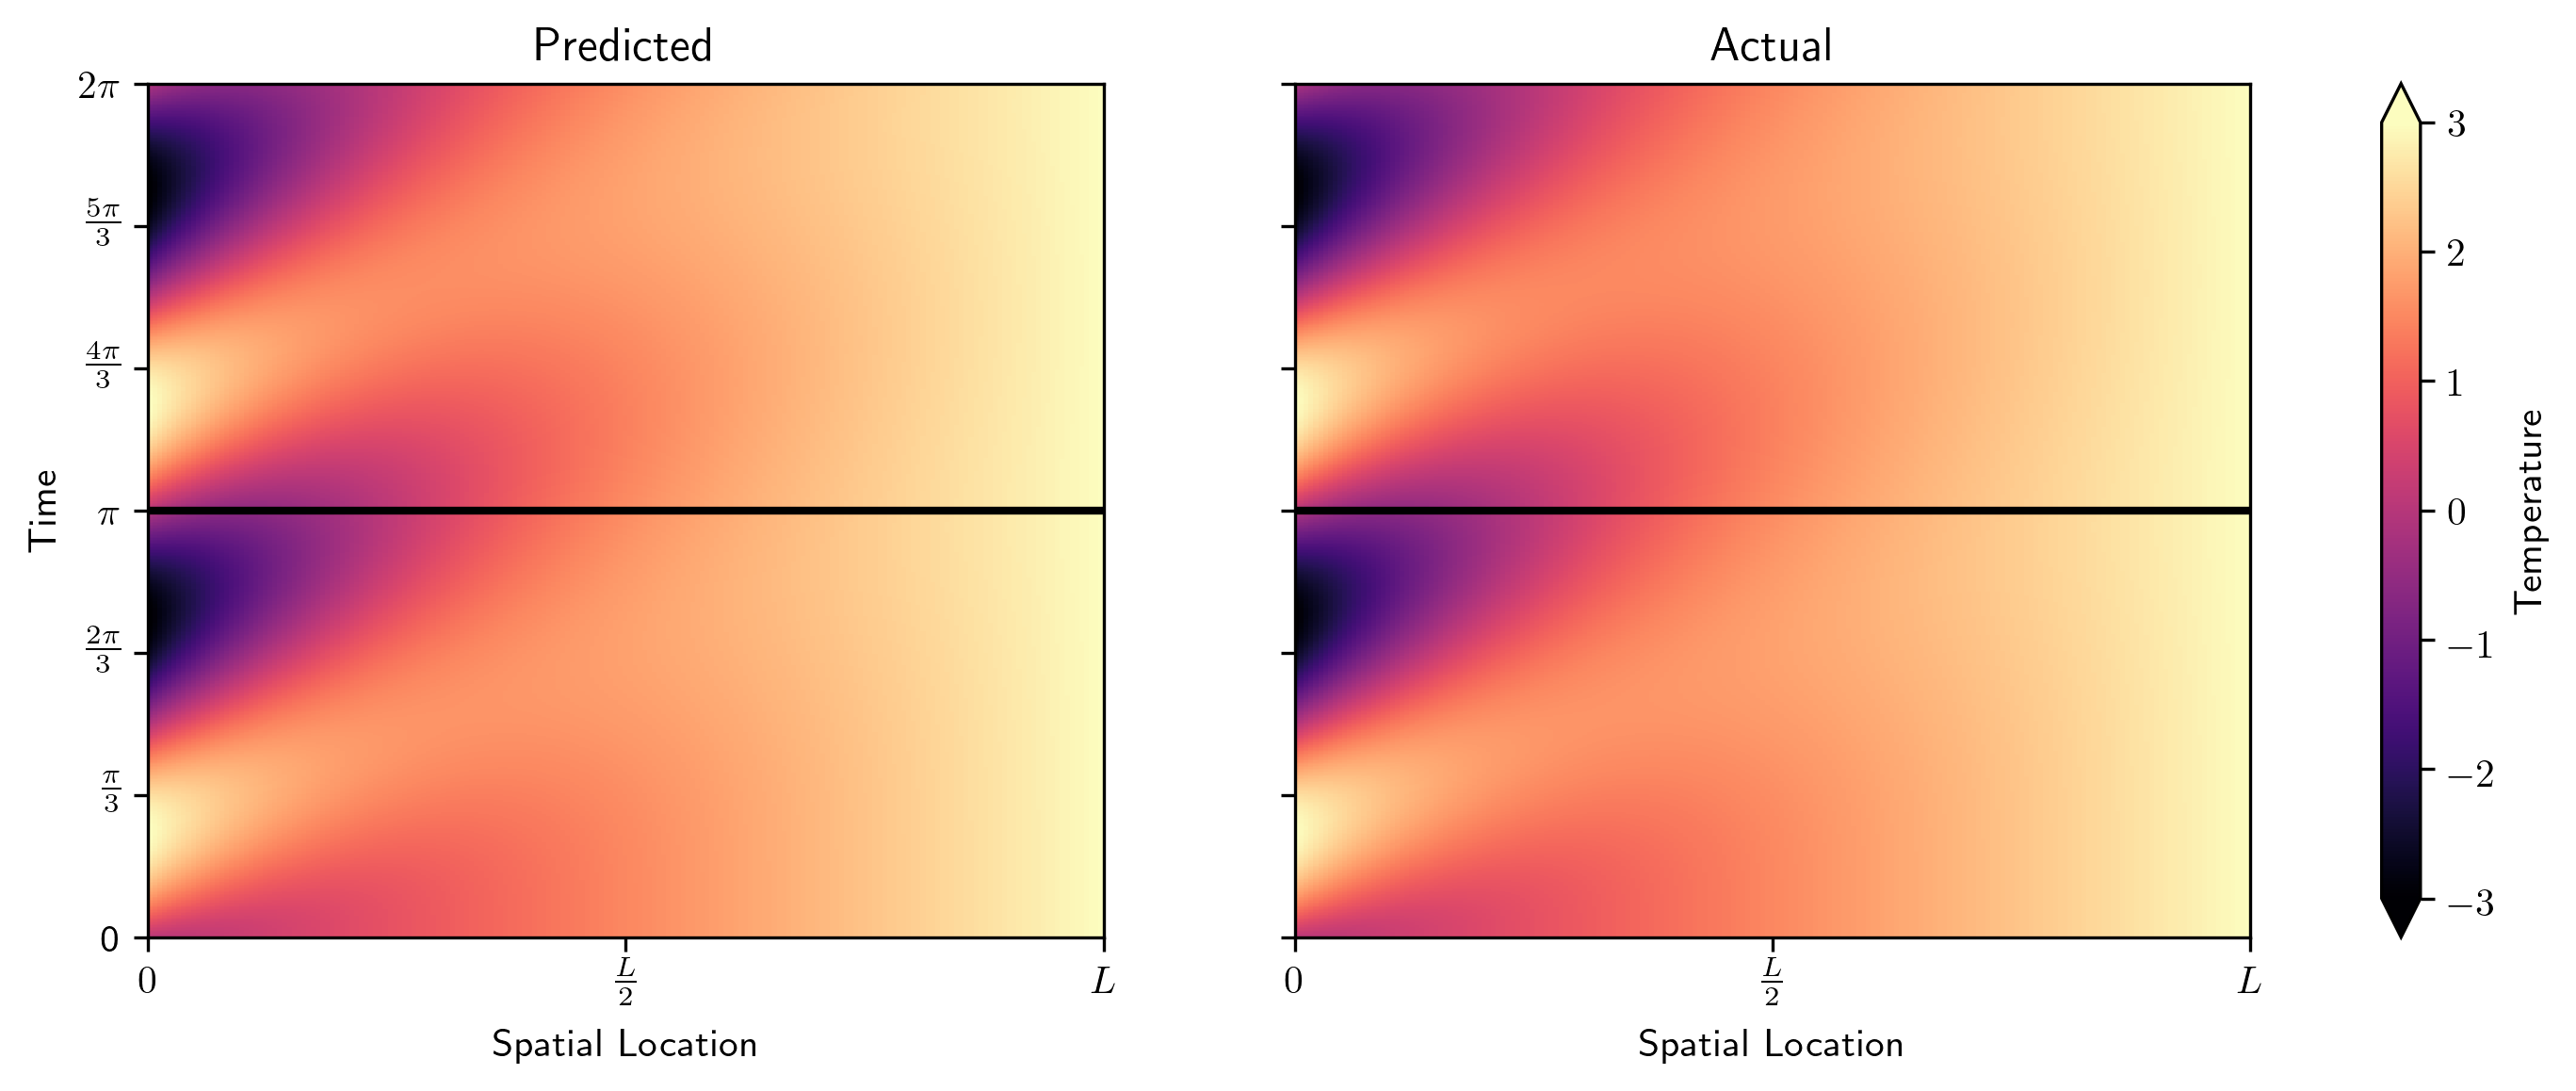

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,4), sharey=True)

map1 = ax1.pcolormesh(XX, YY, x_ROM.T, cmap="magma", vmin=-3, vmax=3)
map2 = ax2.pcolormesh(XX, YY, original_data.T, cmap="magma", vmin=-3, vmax=3)
ax1.set_title("Predicted")
ax2.set_title("Actual")

for ax in [ax1, ax2]:
    ax.axhline(y=np.pi, c='k', lw=2)
    ax.axis([x.min(), x.max(), 0, 2*np.pi])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel("Spatial Location")
ax1.set_ylabel("Time")
fig.colorbar(map1, ax=[ax1, ax2], label="Temperature", extend="both")
plt.show()

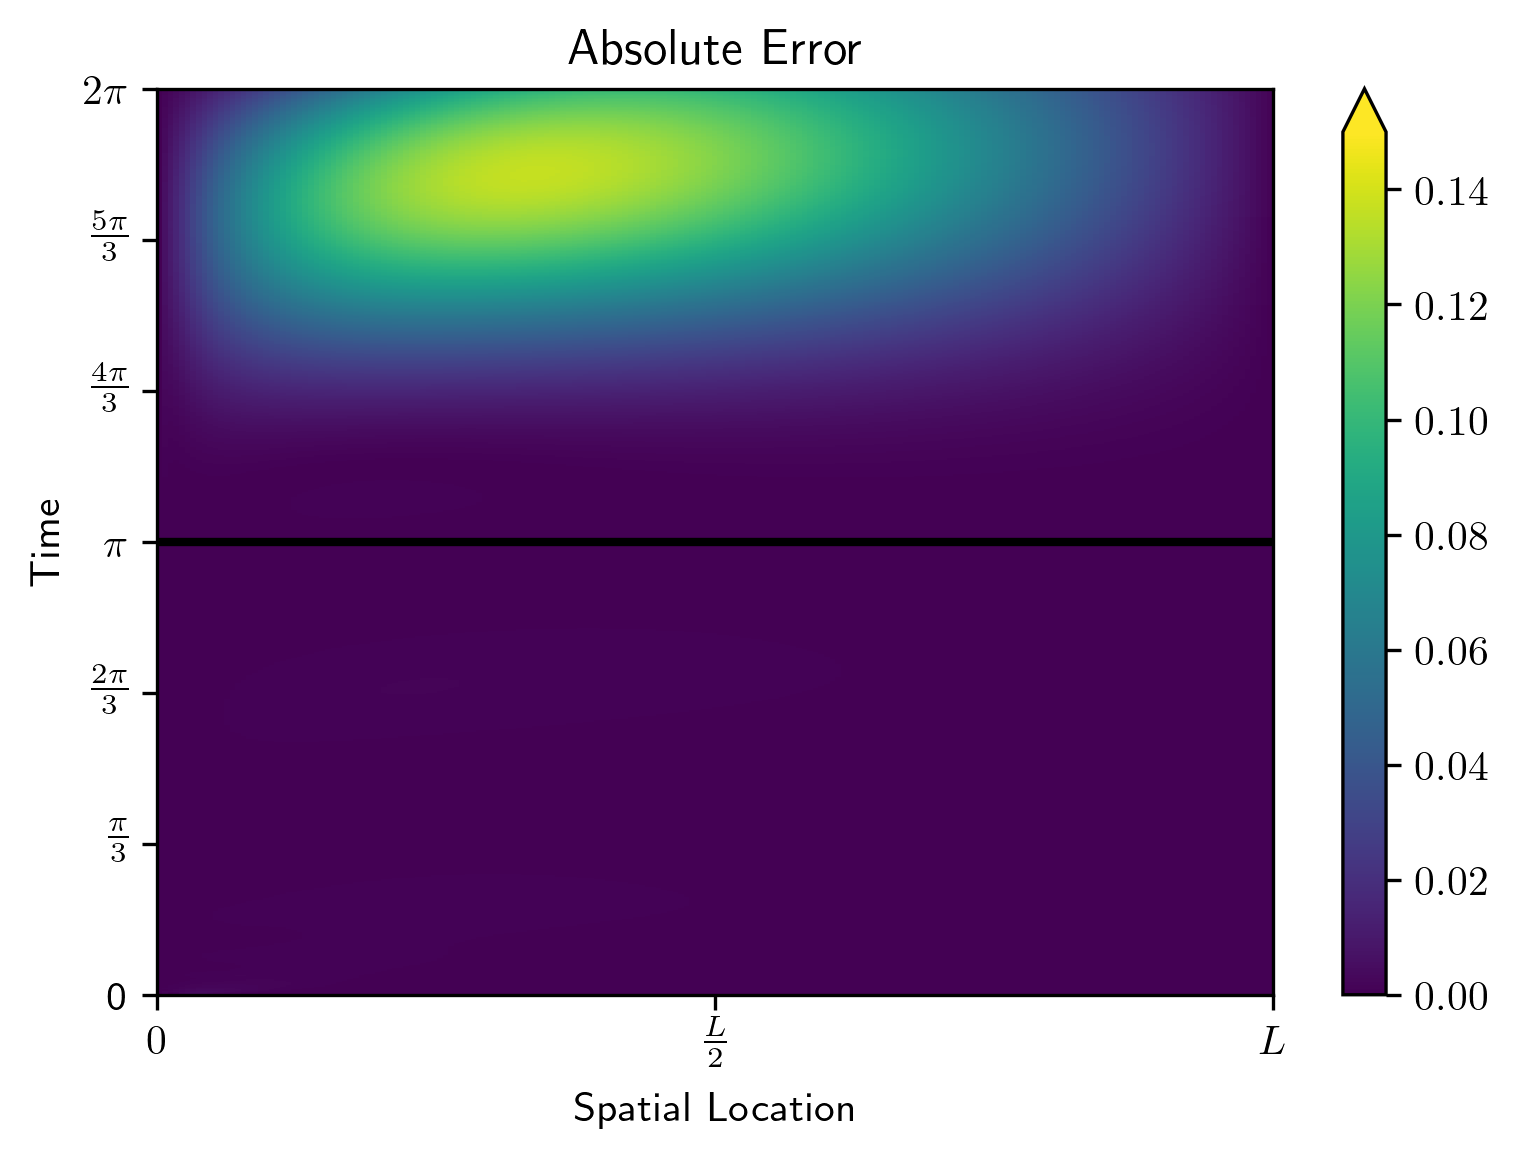

In [11]:
maperr = plt.pcolormesh(XX, YY, np.abs(x_ROM - original_data).T, vmin=0, vmax=.15)
plt.axhline(y=np.pi, c='k', lw=2)

plt.axis([x.min(), x.max(), 0, 2*np.pi])
plt.xlabel("Spatial Location")
plt.ylabel("Time")
plt.xticks(xticks, xticklabels)
plt.yticks(yticks, yticklabels)

plt.title("Absolute Error")

plt.colorbar(maperr, extend="max")
plt.show()